In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from ovejero import forward_modeling, model_trainer

# Comparing Performance to Forward Modeling

__Author:__ Sebastian Wagner-Carena

__Created:__ 04/01/2020

__Last Run:__ 04/01/2020

__Goals:__ Compare the performance of the BNN model to a forward modeling approach

## Forward Modeling NN1

In [2]:
root_path = '/home/swagnercarena/ovejero/'
config_path = root_path + 'configs/nn1_hr.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/',root_path)
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])
recursive_str_checker(cfg)

fow_model = forward_modeling.ForwardModel(cfg)

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn1_hr.h5


True image without noise.


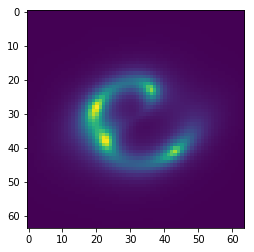

True image with noise.


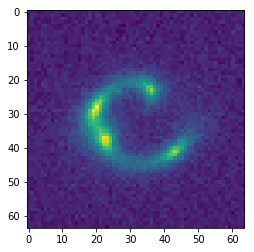

Image data
{'lens_mass_center_x': 0.04447464276155878, 'lens_mass_e1': -0.0019344217722709546, 'src_light_center_x': 0.0666606974830339, 'src_light_R_sersic': 0.5168324861130238, 'img_filename': 'X_0000040.npy', 'lens_mass_e2': -0.21863827627112475, 'src_light_n_sersic': 2.4246063799468183, 'external_shear_gamma_ext': 0.05621896938274424, 'total_magnification': 10.755380317147083, 'src_light_center_y': 0.06062729637749242, 'lens_mass_theta_E': 0.9779771511036928, 'src_light_e2': -0.2979420316652591, 'external_shear_ra_0': 0.04447464276155878, 'lens_mass_center_y': -0.04254594579306117, 'external_shear_dec_0': -0.04254594579306117, 'lens_mass_gamma': 1.7476866515467957, 'external_shear_psi_ext': -0.2187388114473809, 'src_light_e1': 0.2586586502764554, 'src_light_magnitude': 23.24981091894046}


In [3]:
# Select the image we want to forward model.
image_index = 40
fow_model.select_image(image_index)

In [4]:
# Initialize our sampler
n_walkers = 50
save_path_chains = '/home/swagnercarena/ovejero/forward_modeling/%s.h5'%(
    fow_model.image_dict['img_filename'][:-4])
fow_model.initialize_sampler(n_walkers,save_path_chains)

Loaded chains found at /home/swagnercarena/ovejero/forward_modeling/X_0000040.h5
Optimizing the following parameters:
['external_shear_gamma_ext', 'external_shear_psi_ext', 'lens_mass_center_x', 'lens_mass_center_y', 'lens_mass_e1', 'lens_mass_e2', 'lens_mass_gamma', 'lens_mass_theta_E', 'src_light_R_sersic', 'src_light_center_x', 'src_light_center_y', 'src_light_e1', 'src_light_e2', 'src_light_magnitude', 'src_light_n_sersic']


In [5]:
# And run the sampler
# n_samps = 500
# fow_model.run_sampler(n_samps)

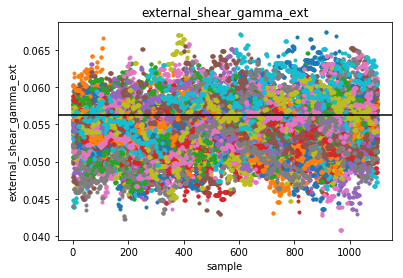

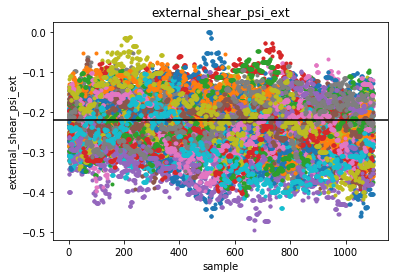

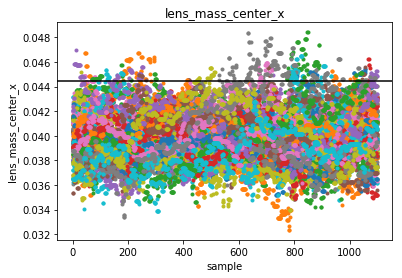

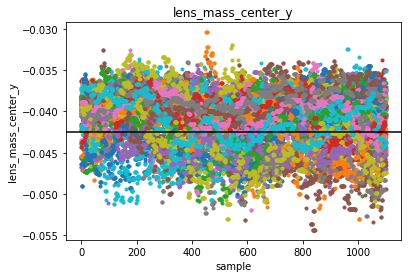

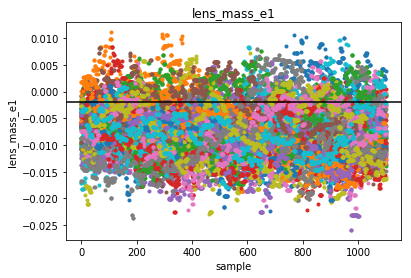

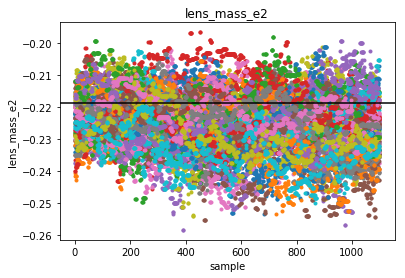

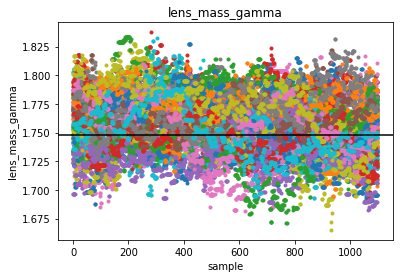

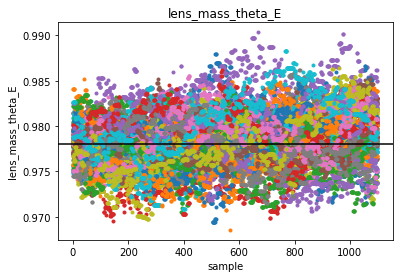

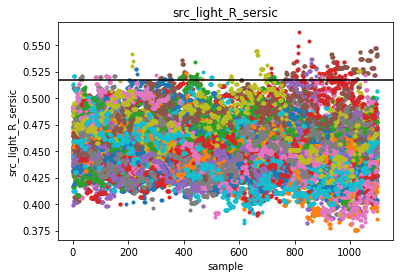

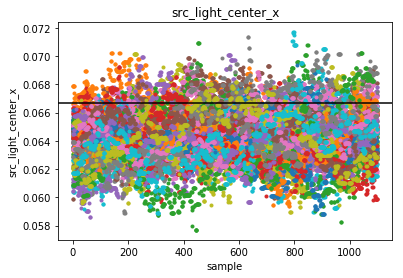

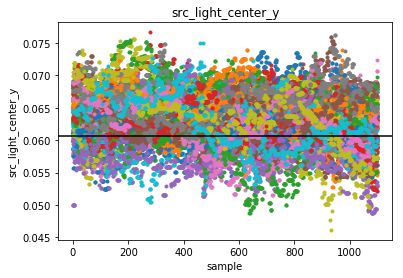

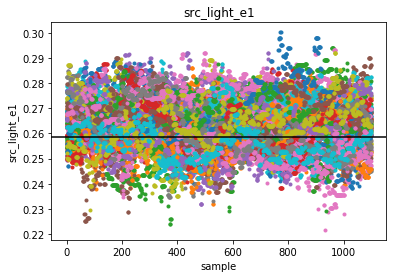

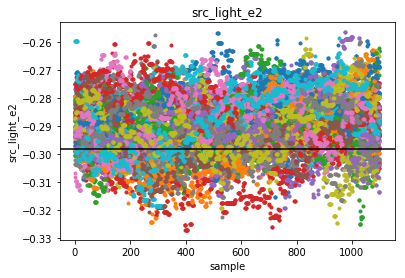

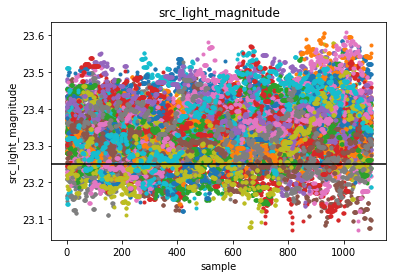

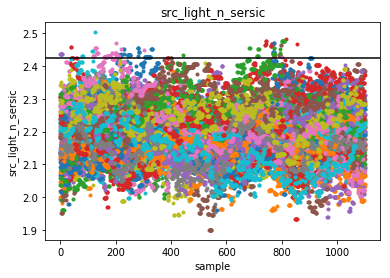

In [6]:
# Let's take a look at the chains to make sure they seem converged
burnin = 1500
fow_model.plot_chains(burnin)

Loading samples from /home/swagnercarena/ovejero/forward_modeling/nn1_X_0000040_samps


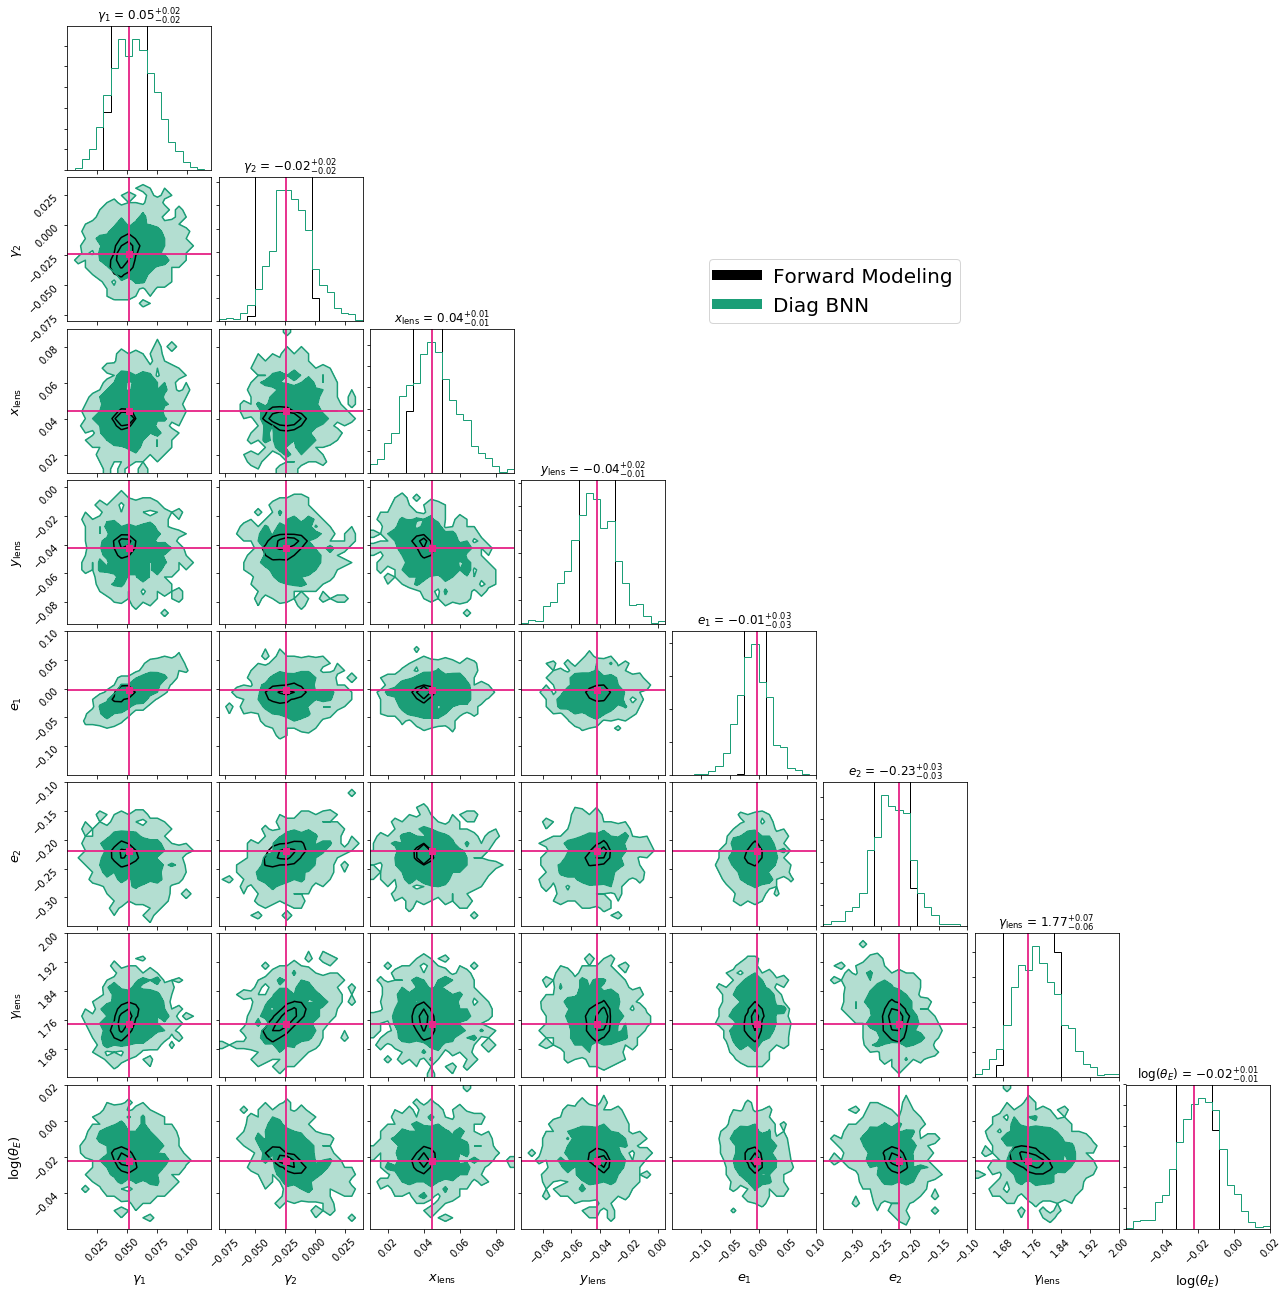

In [7]:
# Now let's look at the corner plot of the parameters we care about (the lens parameters)
num_samples = 1000
sample_save_dir = '/home/swagnercarena/ovejero/forward_modeling/nn1_%s_samps'%(
    fow_model.image_dict['img_filename'][:-4])
color_map = ['#000000','#1b9e77']
truth_color = '#e7298a'
plot_limits = [(0.00,0.12),(-0.08,0.04),(0.01,0.09),(-0.095,0.005),(-0.15,0.10),(-0.35,-0.10),(1.6,2.0),
              (-0.06,0.02)]
fow_model.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,color_map=color_map,
                                 plot_limits=plot_limits,truth_color=truth_color)

## Forward Modeling NN2

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn2_hr.h5
True image without noise.


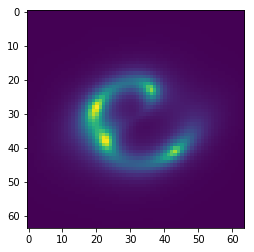

True image with noise.


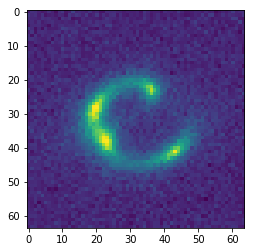

Image data
{'lens_mass_center_x': 0.04447464276155878, 'lens_mass_e1': -0.0019344217722709546, 'src_light_center_x': 0.0666606974830339, 'src_light_R_sersic': 0.5168324861130238, 'img_filename': 'X_0000040.npy', 'lens_mass_e2': -0.21863827627112475, 'src_light_n_sersic': 2.4246063799468183, 'external_shear_gamma_ext': 0.05621896938274424, 'total_magnification': 10.755380317147083, 'src_light_center_y': 0.06062729637749242, 'lens_mass_theta_E': 0.9779771511036928, 'src_light_e2': -0.2979420316652591, 'external_shear_ra_0': 0.04447464276155878, 'lens_mass_center_y': -0.04254594579306117, 'external_shear_dec_0': -0.04254594579306117, 'lens_mass_gamma': 1.7476866515467957, 'external_shear_psi_ext': -0.2187388114473809, 'src_light_e1': 0.2586586502764554, 'src_light_magnitude': 23.24981091894046}
Loaded chains found at /home/swagnercarena/ovejero/forward_modeling/X_0000040.h5
Optimizing the following parameters:
['external_shear_gamma_ext', 'external_shear_psi_ext', 'lens_mass_center_x', 'l

In [8]:
config_path = root_path + 'configs/nn2_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

fow_model = forward_modeling.ForwardModel(cfg)
image_index = 40
fow_model.select_image(image_index)
n_walkers = 50
save_path_chains = '/home/swagnercarena/ovejero/forward_modeling/%s.h5'%(
    fow_model.image_dict['img_filename'][:-4])
fow_model.initialize_sampler(n_walkers,save_path_chains)

Loading samples from /home/swagnercarena/ovejero/forward_modeling/nn2_X_0000040_samps


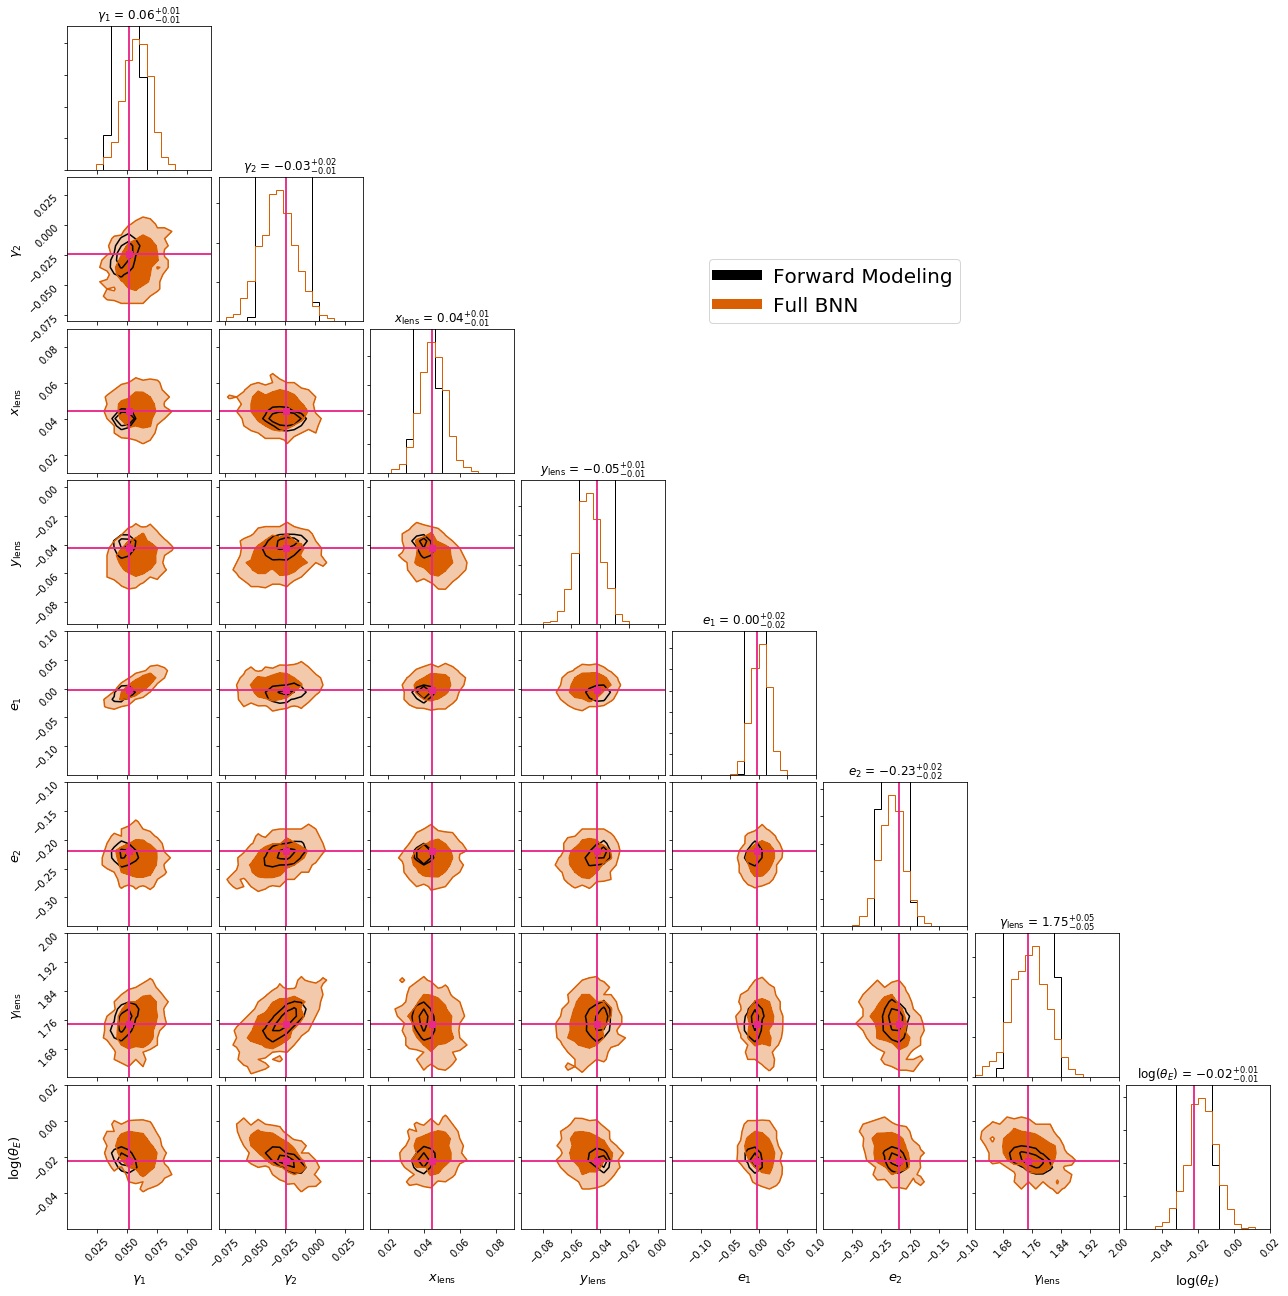

In [9]:
# Now let's look at the corner plot of the parameters we care about (the lens parameters)
num_samples = 1000
sample_save_dir = '/home/swagnercarena/ovejero/forward_modeling/nn2_%s_samps'%(
    fow_model.image_dict['img_filename'][:-4])
color_map = ['#000000','#d95f02']
truth_color = '#e7298a'
plot_limits = [(0.00,0.12),(-0.08,0.04),(0.01,0.09),(-0.095,0.005),(-0.15,0.10),(-0.35,-0.10),(1.6,2.0),
              (-0.06,0.02)]
fow_model.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,color_map=color_map,
                                 plot_limits=plot_limits,truth_color=truth_color)

## Forward Modeling NN3

Is model built: True
Loaded weights /home/swagnercarena/ovejero/models/nn3_lr.h5
True image without noise.


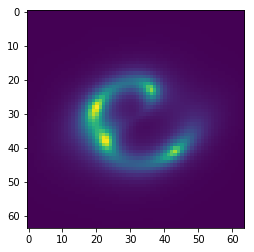

True image with noise.


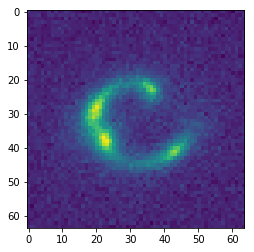

Image data
{'lens_mass_center_x': 0.04447464276155878, 'lens_mass_e1': -0.0019344217722709546, 'src_light_center_x': 0.0666606974830339, 'src_light_R_sersic': 0.5168324861130238, 'img_filename': 'X_0000040.npy', 'lens_mass_e2': -0.21863827627112475, 'src_light_n_sersic': 2.4246063799468183, 'external_shear_gamma_ext': 0.05621896938274424, 'total_magnification': 10.755380317147083, 'src_light_center_y': 0.06062729637749242, 'lens_mass_theta_E': 0.9779771511036928, 'src_light_e2': -0.2979420316652591, 'external_shear_ra_0': 0.04447464276155878, 'lens_mass_center_y': -0.04254594579306117, 'external_shear_dec_0': -0.04254594579306117, 'lens_mass_gamma': 1.7476866515467957, 'external_shear_psi_ext': -0.2187388114473809, 'src_light_e1': 0.2586586502764554, 'src_light_magnitude': 23.24981091894046}
Loaded chains found at /home/swagnercarena/ovejero/forward_modeling/X_0000040.h5
Optimizing the following parameters:
['external_shear_gamma_ext', 'external_shear_psi_ext', 'lens_mass_center_x', 'l

In [10]:
config_path = root_path + 'configs/nn3_lr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

fow_model = forward_modeling.ForwardModel(cfg)
image_index = 40
fow_model.select_image(image_index)
n_walkers = 50
save_path_chains = '/home/swagnercarena/ovejero/forward_modeling/%s.h5'%(
    fow_model.image_dict['img_filename'][:-4])
fow_model.initialize_sampler(n_walkers,save_path_chains)

Loading samples from /home/swagnercarena/ovejero/forward_modeling/nn3_X_0000040_samps


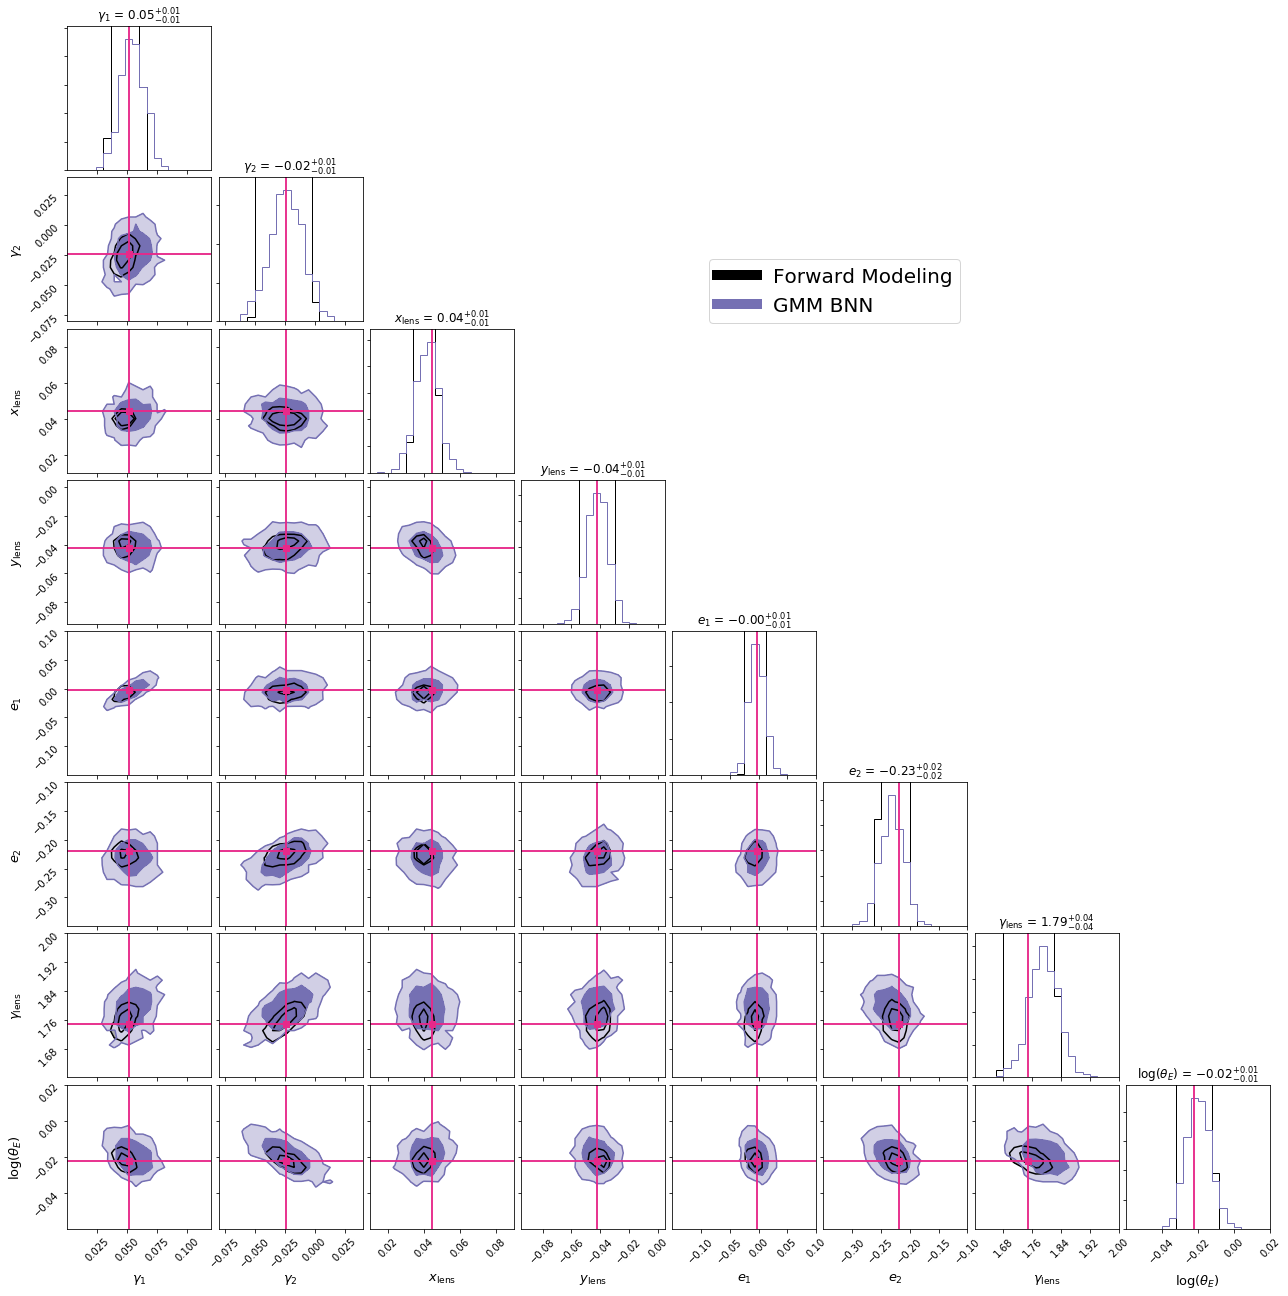

In [11]:
# Now let's look at the corner plot of the parameters we care about (the lens parameters)
num_samples = 1000
sample_save_dir = '/home/swagnercarena/ovejero/forward_modeling/nn3_%s_samps'%(
    fow_model.image_dict['img_filename'][:-4])
color_map = ['#000000','#7570b3']
truth_color = '#e7298a'
plot_limits = [(0.00,0.12),(-0.08,0.04),(0.01,0.09),(-0.095,0.005),(-0.15,0.10),(-0.35,-0.10),(1.6,2.0),
              (-0.06,0.02)]
fow_model.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,color_map=color_map,
                                 plot_limits=plot_limits,truth_color=truth_color)

Loading samples from /home/swagnercarena/ovejero/forward_modeling/nn3_X_0000040_samps


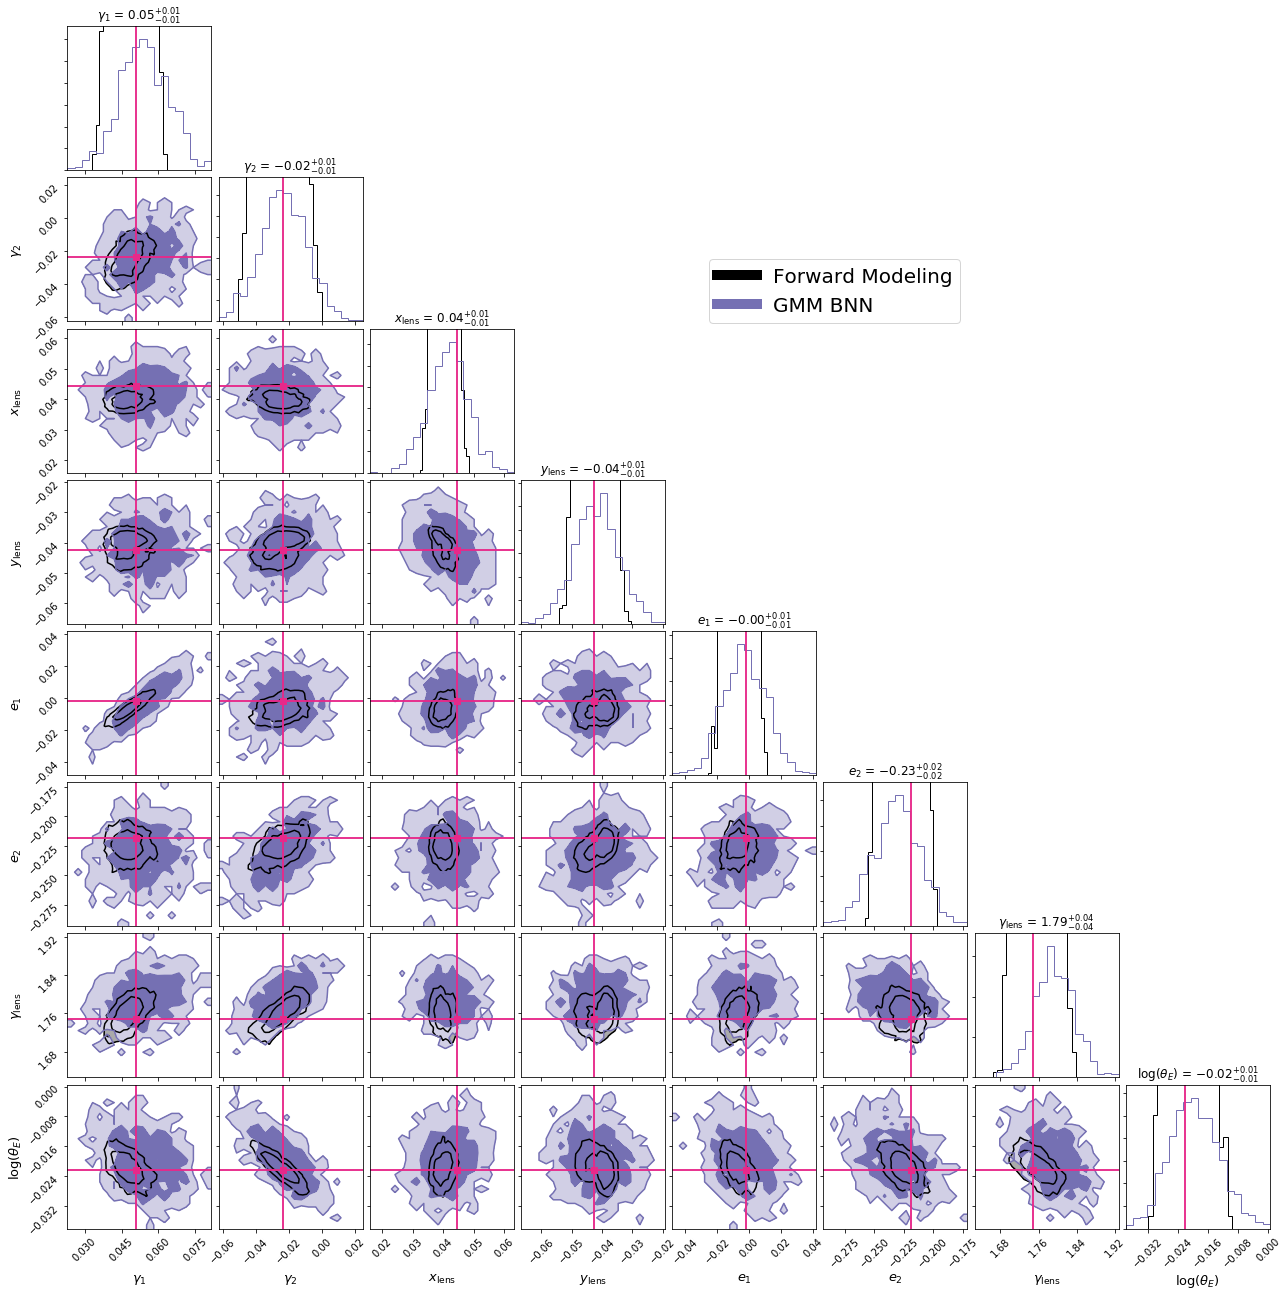

In [12]:
color_map = ['#000000','#7570b3']
truth_color = '#e7298a'
fow_model.plot_posterior_contours(burnin,num_samples,sample_save_dir=sample_save_dir,color_map=color_map,
                                 truth_color=truth_color)